# Efficient Solvers for Large Problems
Until now, we have mostly used one-dimensional geometries with a limited number of nodes and elements. The resulting linear systems have a relatively modest size ($N \times N$, with $N$ in the hundreds or thousands). These can be easily solved using the backslash operator `\` without paying much attention to the memory usage and computation time.

However, when moving to geometries with more elements (such as two-dimensional geometries), the solving time of the linear system can become quite significant. In this notebook, we will investigate the performance of various linear solvers for linear systems of different sizes. This can then be used as a guideline for choosing a linear solver for high performance.

# Linear Solvers
In this section we briefly introduce the different methods available for solving linear systems. In particular, we will focus on _sparse_ linear systems, which are representative of the FEM problems we want to solve efficiently. For easy benchmarking, we will use the interface provided by `LinearSolve.jl`.

## Factorization

 - LU factorization
 - QR factorization
 - SVD factorization

## Iterative methods
Iterative methods are recommended in any of the following situations:
 - the problem is sufficiently large that a factorization is not feasible or would be slow,
 - an effective preconditioner is known in cases where the problem has unfavorable spectral structure,
 - the operator can be represented efficiently as a sparse matrix,
 - the operator is fast, i.e., can be applied with better complexity than if it were materialized as a matrix. Certain fast operators would materialize as dense matrices.

### Krylov

 - Conjugate gradient: For symmetric positive-definite matrices
 - GMRES: For nonsymmetric matrices
 - Bi-CGStab (Stabilized bi-conjugate gradient): For nonsymmetric matrices

### Algebraic Multigrid

# Benchmarking - Tridiagonal Matrix (1D FEM)
In 1D FEM with linear elements we obtain a tri-diagonal symmetric positive definite $A$ matrix. For these linear systems, incomplete factorization coincides with full factorization. Therefore, these systems can be efficiently solved using direct solvers (e.g., Cholesky decomposition) or conjugate gradient (CG) with an incomplete Cholesky (IC) preconditioner.

In [1]:
using LinearAlgebra, SparseArrays
using LinearSolve, IterativeSolvers
using Preconditioners, AlgebraicMultigrid, Krylov, IncompleteLU

using BenchmarkTools
using Plots

In [2]:
function generate_mesh(Nel)
    x = 0:1/Nel:1;

    # Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
    N = length(x);
    points = collect( [x[i], x[i+1]] for i in 1:N-1) 
    edges  = collect( [i, i+1] for i in 1:N-1); 

    elem_ids = 1:length(edges)
    e_group = ones(size(edges));
    
    #..Set the source function 
    fsource(group_id) = 1;
    fsource_elem = map(fsource, e_group);
    
    return x, edges, N, elem_ids, fsource_elem
end

# Compute the length h of an element, given its ID and the global list of elements and points
function compute_element_area(elem_id, e, p)
    area_id = p[e[elem_id][2]] - p[e[elem_id][1]]
    return area_id
end

function assemble_matrices(elem_ids, elems, x, N)
    # Calculate element length h
    elem_area = map(elem_id -> compute_element_area(elem_id, elems, x), elem_ids);
    
    # Generate index vectors
    I = reduce(vcat, view.(elems, Ref([1, 2, 1, 2])))
    J = reduce(vcat, view.(elems, Ref([1, 1, 2, 2])))
    
    # Generate matrix contributions
    Atempl = [1, -1, -1, 1];
    V = reduce(vcat, map(h -> Atempl / h, elem_area));
    
    A = sparse(I, J, V, N, N);
       
    return A
end

assemble_matrices (generic function with 1 method)

In [3]:
N_ = [128, 512, 1024, 2048, 8192, 32768];
N_ = N_ .- 1;

probs = Vector{LinearProblem}();
for (i, Nel) = enumerate(N_)
    x, edges, N, elem_ids, _ = generate_mesh(Nel)
    A = assemble_matrices(elem_ids, edges, x, N);
    f = rand(N);
    
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    A[2,1] = 0; A[end-1,end] = 0;
   
    prob = LinearProblem(A, f);
    push!(probs, prob);
end

In [4]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1

1

## Reference

In [5]:
ref_time = zeros(1, length(probs))
ref_mem  = zeros(1, length(probs))

for (j, prob) in enumerate(probs)
    A = prob.A;
    f = prob.b;
    bm = @benchmark begin
        $A \ $f
    end

    ref_time[j] = mean(bm).time * 1e-6;
    ref_mem[j]  = bm.memory / 1024;
end

In [5]:
ref_time = [0.0397462  0.125646  0.231863  0.473033  1.89972  7.84068];
ref_mem  = [54.1406  210.406  418.406  834.328  3330.25  13314.2];

## Benchmarking

In [6]:
algs = (
    KLUFactorization(),
    KrylovJL_CG(),
    KrylovJL_CG()
)
preconds = (
    nothing,
    A -> CholeskyPreconditioner(A, 2),
    A -> ilu(A, τ = 0.1)
)

time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        p = preconds[i];
        if p == nothing
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg).u
            end
        else
            pre = p(prob.A);
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg, Pl = $pre).u
            end
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [16]:
time = [0.054758    0.161704   0.274792   0.533133   2.28053   10.9857
 0.00902289  0.0273575  0.0470528  0.0828946  0.346204   2.47284
 0.00925551  0.0312317  0.0469899  0.0944572  0.358883   2.32406];
mem = [86.8125  309.359   605.055  1196.91   4748.73  18956.8
 20.75     75.625   147.469   291.391  1154.53   4610.53
 20.75     75.5938  147.438   291.359  1154.5    4610.5];

## Results: Computation Time and Memory

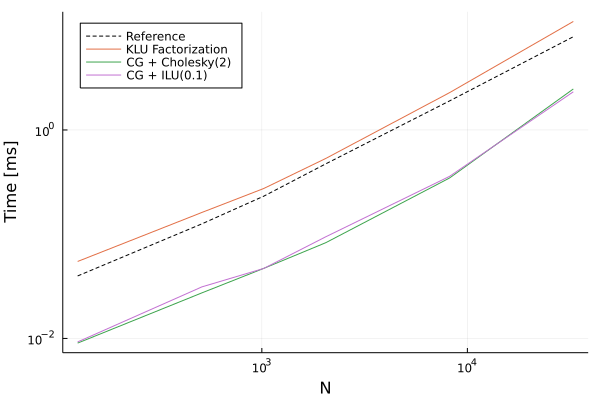

In [9]:
alg_labels = ["KLU Factorization" "CG + Cholesky(2)" "CG + ILU(0.1)"];
plot(N_, ref_time', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft)
plot!(N_, time', labels = alg_labels)

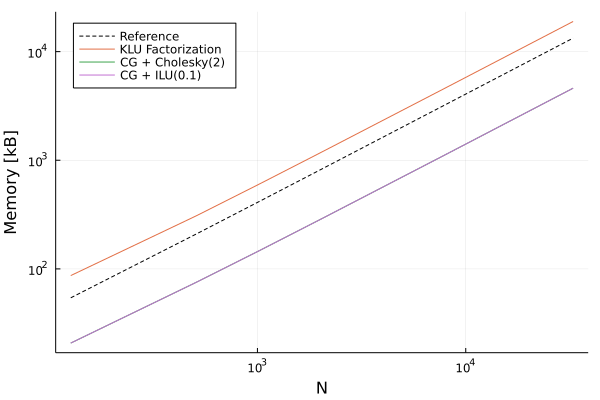

In [10]:
plot(N_, ref_mem', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft)
plot!(N_, mem', labels = alg_labels)

# Benchmarking - Symmetric Posdef (2D FEM)
In case of the symmetric positive-definite systems we obtain in two-dimensional FEM, we prefer to use conjugate gradient (CG) with an algebraic multigrid (AMG) preconditioner (https://ieeexplore.ieee.org/abstract/document/717782). The structure of the 2D FEM $A$ matrix does not have the regularity that we observed in the linear 1D case.

In [44]:
N_ = [128, 512, 1024, 2048, 8192];

probs = Vector{LinearProblem}();
for (i, N) = enumerate(N_)
    # Artificially construct a symmetric positive definite matrix
    #  without any requirements on its structure.
    B = sprand(N, N, 0.01)
    A = B + B' + 30I;
    f = rand(N)
    
    A[1,:]   = zeros(N);  A[:,1] = zeros(N);    A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[:,end] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    posdef = isposdef(A);
    symm   = issymmetric(A);
    print("N = $N: posdef = $posdef, symmetric = $symm\n")
   
    prob = LinearProblem(A, f);
    push!(probs, prob);
end

N = 128: posdef = true, symmetric = true
N = 512: posdef = true, symmetric = true
N = 1024: posdef = true, symmetric = true
N = 2048: posdef = true, symmetric = true
N = 8192: posdef = true, symmetric = true


## Reference

In [49]:
ref_time = zeros(1, length(probs))
ref_mem  = zeros(1, length(probs))

for (j, prob) in enumerate(probs)
    A = prob.A;
    f = prob.b;
    bm = @benchmark begin
        $A \ $f
    end

    ref_time[j] = mean(bm).time * 1e-6;
    ref_mem[j]  = bm.memory / 1024;
end

In [52]:
ref_time = [0.0794874  4.82245  18.5228  85.7713  2120.99]
ref_mem  = [59.1562  1569.72  8808.26  45270.8  9.13847e5]

1×5 Matrix{Float64}:
 59.1562  1569.72  8808.26  45270.8  913847.0

## Benchmarking

In [56]:
algs = (
    KrylovJL_CG(),
    KrylovJL_CG()
)
preconds = (
    A -> AMGPreconditioner{RugeStuben}(A),
    A -> AMGPreconditioner{SmoothedAggregation}(A)
)

time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        p = preconds[i];
        if p == nothing
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg).u
            end
        else
            pre = p(prob.A);
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg, Pl = $pre).u
            end
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [59]:
time = [0.0368133  0.560393  1.81332  4.44891  93.1163
 0.0305023  0.279907  1.01872  3.40186  84.4185];
mem  = [21.375  140.312  432.062  1530.23  21788.1
 21.375  140.312  432.062  1530.23  21788.1];

## Results: Computation Time and Memory

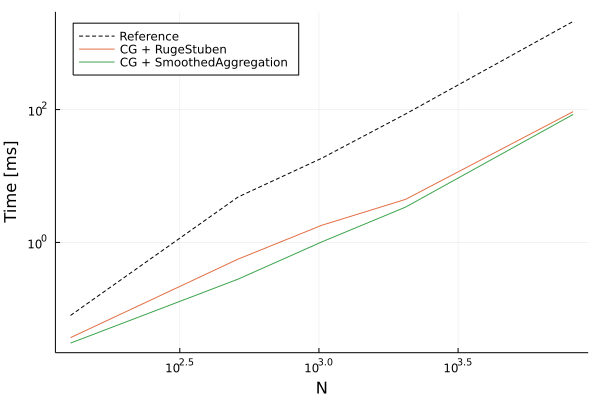

In [60]:
alg_labels = ["CG + RugeStuben" "CG + SmoothedAggregation"];
plot(N_, ref_time', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft)
plot!(N_, time', labels = alg_labels)

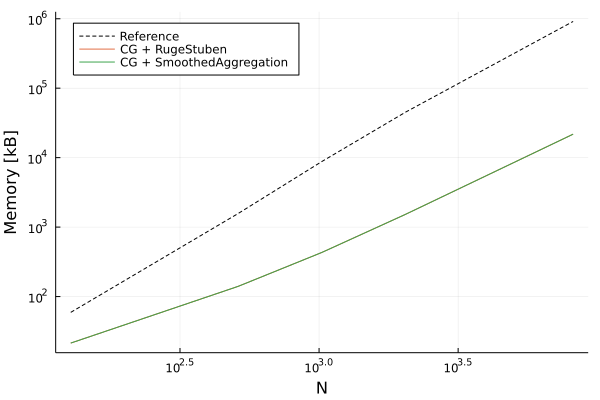

In [61]:
plot(N_, ref_mem', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft)
plot!(N_, mem', labels = alg_labels)

# Benchmarking - Complex Symmetric (2D FEM + eddy currents)
When we want to include eddy currents in our time-harmonic magnetics model, the $A$ matrix entries corresponding to cells with a non-zero conductivity will be complex. Therefore, the matrix will no longer be positive definite. In this case we cannot use CG, and instead use GMRES ([Generalized Minimal Residual Method](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method)) or IDR (Induced Dimension Reduction). See also https://ieeexplore.ieee.org/abstract/document/877730.

In [11]:
N_ = [128, 512, 1024, 2048];

probs = Vector{LinearProblem}();
for (i, N) = enumerate(N_)
    # Artificially construct a symmetric positive definite matrix
    #  without any requirements on its structure.
    B = sprand(Complex{Float64}, N, N, 0.01)
    A = B + transpose(B) + 30I;
    f = rand(Complex{Float64}, N)
    
    A[1,:]   = zeros(N);  A[:,1] = zeros(N);    A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[:,end] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    posdef = isposdef(A);
    symm   = issymmetric(A);
    print("N = $N: posdef = $posdef, symmetric = $symm\n")
   
    prob = LinearProblem(A, f);
    push!(probs, prob);
end

N = 128: posdef = false, symmetric = true
N = 512: posdef = false, symmetric = true
N = 1024: posdef = false, symmetric = true
N = 2048: posdef = false, symmetric = true


## Reference

In [74]:
ref_time = zeros(1, length(probs))
ref_mem  = zeros(1, length(probs))

for (j, prob) in enumerate(probs)
    A = prob.A;
    f = prob.b;
    bm = @benchmark begin
        $A \ $f
    end

    ref_time[j] = mean(bm).time * 1e-6;
    ref_mem[j]  = bm.memory / 1024;
end

In [3]:
ref_time = [0.264313  21.364  115.744  884.877];
ref_mem  = [224.555  7386.12  51233.0  2.78493e5];

## Benchmarking

In [28]:
? idrs

search: idrs idrs! findfirst IndexCartesian ModifiedGramSchmidt splitdrive isdir



```
idrs(A, b; s = 8, kwargs...) -> x, [history]
```

Same as [`idrs!`](@ref), but allocates a solution vector `x` initialized with zeros.


In [32]:
function IterativeSolversJL_IDRS(A,b,u,p,newA,Pl,Pr,solverdata;verbose=true, kwargs...)
    u = idrs(A, b)
    return u
end

algs = (
    KrylovJL_GMRES(),
    LinearSolveFunction(IterativeSolversJL_IDRS)
)
preconds = (
    nothing,
    nothing,
)

time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        p = preconds[i];
        if p == nothing
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg).u
            end
        else
            pre = p(prob.A);
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg, Pl = $pre).u
            end
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [35]:
time = [0.0485303  0.183666  0.680297  2.12752
 0.0655262  0.333504  1.08691   3.11538];
mem  = [120.531   520.656  1273.16  3495.11
  91.1406  407.141  1049.11  3049.91];

## Results: Computation Time and Memory

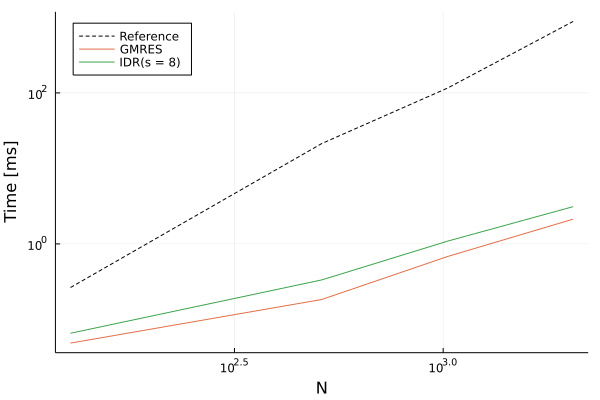

In [36]:
alg_labels = ["GMRES" "IDR(s = 8)"];
plot(N_, ref_time', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft)
plot!(N_, time', labels = alg_labels)

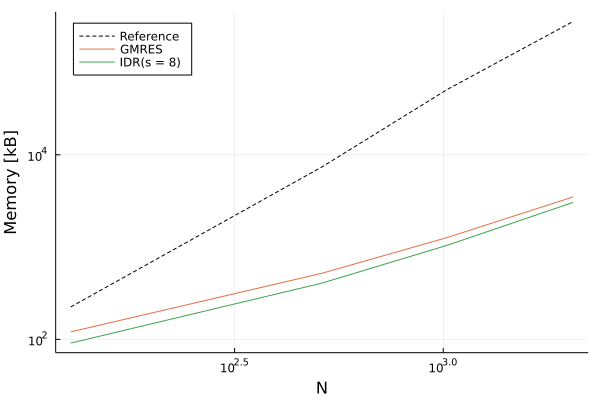

In [38]:
plot(N_, ref_mem', color = :black, linestyle = :dash, label = "Reference", xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft)
plot!(N_, mem', labels = alg_labels)